<a href="https://colab.research.google.com/github/urmilapol/urmilapolprojects/blob/master/thyroiddatamodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

No path specified. Models will be saved in: "AutogluonModels/ag-20250606_084904"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
Memory Avail:       11.18 GB / 12.67 GB (88.3%)
Disk Space Avail:   65.06 GB / 107.72 GB (60.4%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competition

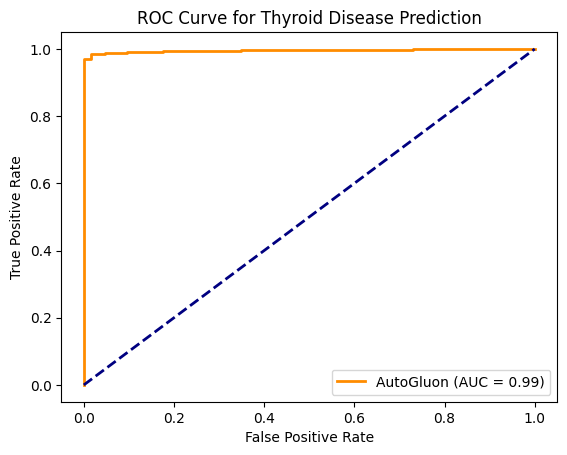

In [15]:
import pandas as pd
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Load your thyroid disease dataset (replace with your file)
df = pd.read_csv('/content/sample_data/hypothyroid.csv')

# Assume 'target' is the column to predict (e.g., disease presence)
train_data = df.sample(frac=0.8, random_state=42)
test_data = df.drop(train_data.index)

# Define label column
label = 'binaryClass'

# Train AutoML model
# Increase time_limit for potentially better performance (optional)
predictor = TabularPredictor(label=label, eval_metric='roc_auc').fit(train_data, time_limit=600) # Reduced time_limit for demonstration

# Evaluate on test set
performance = predictor.evaluate(test_data)

# Feature importance
importances = predictor.feature_importance(test_data)

# Predict and get probabilities
y_pred = predictor.predict(test_data)

# Get the name of the positive class label from the predictor
positive_class_label = predictor.class_labels[1] # Assuming the positive class is at index 1

# Access the probability column using the positive class label
y_prob = predictor.predict_proba(test_data)[positive_class_label]

# Visualization: ROC Curve
# Pass the positive class label explicitly to roc_curve
fpr, tpr, _ = roc_curve(test_data[label], y_prob, pos_label=positive_class_label)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AutoGluon (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Thyroid Disease Prediction')
plt.legend(loc="lower right")
plt.show()

In [16]:
from IPython.display import display
import pandas as pd
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import numpy as np # Import numpy for potential label encoding if needed


# Load your thyroid disease dataset (replace with your file)
df = pd.read_csv('/content/sample_data/hypothyroid.csv')

# Assume 'target' is the column to predict (e.g., disease presence)
# It's generally good practice to handle missing values and categorical features
# AutoGluon often handles these internally, but preprocessing can sometimes help
# For demonstration, we'll use the raw data for now.

# Define label column
label = 'binaryClass'

# Check the unique values in the label column to understand the classes
print(f"Unique values in label column '{label}': {df[label].unique()}")


# Split data into train and test sets
train_data = df.sample(frac=0.8, random_state=42)
test_data = df.drop(train_data.index)

print(f"\nTraining data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


# Train AutoML model
# Increase time_limit for potentially better performance (optional)
# We keep eval_metric='roc_auc' as it was used before, but leaderboard will show accuracy
predictor = TabularPredictor(label=label, eval_metric='roc_auc').fit(train_data, time_limit=600) # Reduced time_limit for demonstration

# Evaluate on test set (this gives overall performance of the best model/ensemble)
performance = predictor.evaluate(test_data)
print("\nOverall performance of the best model/ensemble:")
print(performance)

# Feature importance (optional)
# importances = predictor.feature_importance(test_data)
# print("\nFeature Importances:")
# display(importances)

# --- Code for comparing individual models ---

# Get the leaderboard to see individual model performance
# Silent=True to reduce verbose output
leaderboard = predictor.leaderboard(test_data, silent=True)
print("\n--- Model Leaderboard (includes accuracy and other metrics) ---")
display(leaderboard) # Display the leaderboard as a table

# Get the list of models trained by AutoGluon
model_list = predictor.get_model_names()

# Get the true labels from the test data
y_true = test_data[label]

# Get the unique class labels in the correct order from the predictor
# This is crucial for ensuring the confusion matrix axes are correct
class_labels = predictor.class_labels
print(f"\nClass labels ordered by predictor: {list(class_labels)}")


print("\n--- Evaluating individual base models with Confusion Matrices ---")

# Iterate through each trained model
for model_name in model_list:
    # Skip ensemble models for individual confusion matrix comparison
    # You could potentially analyze ensembles as well, but it might be less insightful
    # for comparing base models.
    if 'ensemble' in model_name.lower() or 'weightedensemble' in model_name.lower():
        continue

    print(f"\n--- Model: {model_name} ---")

    try:
        # Get predictions for the current model on the test data
        y_pred_model = predictor.predict(test_data, model=model_name)

        # Ensure labels are consistent for confusion matrix calculation
        # Convert to string as AutoGluon often returns string labels
        y_true_str = y_true.astype(str)
        y_pred_model_str = y_pred_model.astype(str)

        # Calculate the confusion matrix
        # Use the class_labels from the predictor to ensure correct order
        # .astype(str) is added to class_labels to ensure consistency with string labels
        cm = confusion_matrix(y_true_str, y_pred_model_str, labels=class_labels.astype(str))

        print("Confusion Matrix:")
        print(cm)

        # Visualize the confusion matrix
        plt.figure(figsize=(6, 5))
        # Use class_labels for display_labels
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
        disp.plot(cmap=plt.cm.Blues, values_format='d') # values_format='d' for integer counts
        plt.title(f'Confusion Matrix for {model_name}')
        plt.show()

        # You can optionally calculate and print accuracy for this specific model
        # from sklearn.metrics import accuracy_score
        # accuracy = accuracy_score(y_true_str, y_pred_model_str)
        # print(f"Accuracy: {accuracy:.4f}")

    except Exception as e:
        print(f"Could not evaluate model {model_name}: {e}")


# --- Optional: ROC Curve for the best model (as in the original code) ---
# Predict probabilities using the best model (or ensemble)
try:
    # Get the name of the positive class label from the predictor
    # AutoGluon stores class labels in order, usually index 0 is the negative class
    # and index 1 is the positive class, but it's good to verify.
    # Based on the error message and typical binary classification, let's assume index 1 is positive.
    positive_class_label = predictor.class_labels[1]
    print(f"\nAssuming positive class is: '{positive_class_label}' for ROC curve.")

    # Access the probability column using the positive class label
    # .predict_proba returns a dataframe where columns are class labels
    y_prob = predictor.predict_proba(test_data)[positive_class_label]

    # Visualization: ROC Curve for the best model/ensemble
    # Ensure y_true is of a type compatible with roc_curve if needed (e.g., convert 'P'/'N' to 1/0 if pos_label is not used)
    # Since we are using pos_label='P' or 'N', y_true can remain as string
    fpr, tpr, _ = roc_curve(test_data[label], y_prob, pos_label=positive_class_label)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Best AutoGluon Model (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Thyroid Disease Prediction')
    plt.legend(loc="lower right")
    plt.show()

except Exception as e:
    print(f"\nCould not generate ROC curve: {e}")

No path specified. Models will be saved in: "AutogluonModels/ag-20250606_085500"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
Memory Avail:       11.18 GB / 12.67 GB (88.2%)
Disk Space Avail:   65.01 GB / 107.72 GB (60.4%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competition

Unique values in label column 'binaryClass': ['P' 'N']

Training data shape: (3018, 30)
Test data shape: (754, 30)


			Note: Converting 19 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 2): ['TBG measured', 'TBG']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('object', []) : 27 | ['age', 'sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('category', [])  :  8 | ['age', 'sex', 'TSH', 'T3', 'TT4', .


Overall performance of the best model/ensemble:
{'roc_auc': np.float64(0.9947166517354651), 'accuracy': 0.9840848806366048, 'balanced_accuracy': np.float64(0.9841040130475731), 'mcc': np.float64(0.9060308612110883), 'f1': 0.9912536443148688, 'precision': 0.9985315712187959, 'recall': 0.984081041968162}

--- Model Leaderboard (includes accuracy and other metrics) ---


,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost,0.995498,0.997949,roc_auc,0.027231,0.009338,9.262449,0.027231,0.009338,9.262449,1,True,5
1,WeightedEnsemble_L2,0.994717,0.998690,roc_auc,0.199814,0.130295,10.537884,0.004346,0.001014,0.093966,2,True,12
2,NeuralNetFastAI,0.992741,0.988095,roc_auc,0.047668,0.024345,5.275609,0.047668,0.024345,5.275609,1,True,8
3,RandomForestEntr,0.984701,0.984051,roc_auc,0.133214,0.113154,1.283603,0.133214,0.113154,1.283603,1,True,4
4,RandomForestGini,0.980096,0.980149,roc_auc,0.132571,0.111063,1.244321,0.132571,0.111063,1.244321,1,True,3
5,LightGBM,0.961064,0.950558,roc_auc,0.024164,0.011625,0.688559,0.024164,0.011625,0.688559,1,True,2
6,LightGBMLarge,0.957435,0.938198,roc_auc,0.052627,0.025514,1.017793,0.052627,0.025514,1.017793,1,True,11
7,ExtraTreesEntr,0.951141,0.951640,roc_auc,0.168236,0.119943,1.181468,0.168236,0.119943,1.181468,1,True,7
8,XGBoost,0.941550,0.899749,roc_auc,0.034939,0.010269,2.378952,0.034939,0.010269,2.378952,1,True,9
9,ExtraTreesGini,0.940861,0.944520,roc_auc,0.160217,0.121304,1.158908,0.160217,0.121304,1.158908,1,True,6


AttributeError: 'TabularPredictor' object has no attribute 'get_model_names'

In [17]:
# prompt: Using dataframe leaderboard: line

import altair as alt

# Create a line chart using Altair
# X-axis is 'fit_time', Y-axis is 'score_test'
chart = alt.Chart(leaderboard).mark_line().encode(
    x='fit_time',
    y='score_test'
)

# Display the chart
chart

alt.Chart(...)